# Udacity Data Scientist Nanodegree Capstone Project - Starbucks

## Project Overview

Here, I will analyze the subject of offer optimization. What is **offer**? The offer means such as coupon or information about new product. We are provided the data of customer purchases and offer related activity (receive offer, open offer, complete offer) on the Starbucks rewards mobile app.   
Below, I will show the information of provided data.

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed (main data)

If you are interested more detail, please see [docs from udacity](https://github.com/shyaginuma/udacity_capstone_starbucks/blob/master/docs). This directry contains detail information about overview and data.

## Problem Statement / Metrics

The problem I will solve here is **Which offer should we send to each customer?**. I aim to maximize sales by solving this problem.  
Speaking more, if we can send offer which maxmize sales of customer, We can achieve that. So, I will try to predict purchases of customer when we sent each offer with machine learning model.  
It is important to note here that the offer has expiration date. So, data has purchases which is not related to offer and we need to process data.

I will use [R2 score](https://en.wikipedia.org/wiki/Coefficient_of_determination) to measure performance of a model. Because it is scaled and useful.

## Data Cleaning

In this part, I will clean data and create some features. When finish the process, the data will look like below.

person | offer_id | offer_related_purchase($) | other features...
-- | -- | -- | --
1 | A | 10 | ...
1 | B | 20 | ...
2 | A | 30 | ...
2 | C | 40 | ...
... | ... | ... | ...

The rows are unique in combination of person and offer_id, and the target valuable is the amount of offer related purchase.  
I processed the data paying attention to below parts.

* There is the case a user received offer but never open the offer and buy products. It should not be thought offer related purchase.
* There is the case a user didn't receive offer but purchase product. It also should not be thought offer related purchase.
* Offer has expiration date, So if there is purchases which over offer deadline, It also should not be thought offer related purchase.

Because I want to prevent the notebook becoming too complicated, I divided the cleaning of the data in .py file.
So, if you are interested in the processing details, please see [preprocess.py](https://github.com/shyaginuma/udacity_capstone_starbucks/blob/master/py/preprocess.py) and [feature_engineering.py](https://github.com/shyaginuma/udacity_capstone_starbucks/blob/master/py/feature_engineering.py).

Now, Let's start analysis with import necessary library!!

In [109]:
import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from fastprogress import master_bar, progress_bar

import sys
sys.path.append('../py')
from preprocess import preprocess
from feature_engineering import create_feature

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# load data
portfolio = pd.read_json('../data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../data/profile.json', orient='records', lines=True)
transcript = pd.read_json('../data/transcript.json', orient='records', lines=True)

In [3]:
# process data
cleaned_data = preprocess(portfolio, transcript)
cleaned_data = create_feature(cleaned_data, portfolio, profile)
cleaned_data.head()

,person,offer_id,amount,age,income,difficulty,duration,offer_type,reward,num_channel,...,discount_ratio,gender_F,gender_M,gender_O,registar_year_2013,registar_year_2014,registar_year_2015,registar_year_2016,registar_year_2017,registar_year_2018
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57,33,72000.0,0,4,informational,0,3,...,0.00,0,1,0,0,0,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,33,72000.0,0,3,informational,0,3,...,0.00,0,1,0,0,0,0,0,1,0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,14.11,33,72000.0,5,5,bogo,5,4,...,1.00,0,1,0,0,0,0,0,1,0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,82.76,33,72000.0,10,10,discount,2,4,...,0.20,0,1,0,0,0,0,0,1,0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,45.08,40,57000.0,20,10,discount,5,2,...,0.25,0,0,1,0,0,0,0,0,1


In [4]:
# check the shape
cleaned_data.shape

(33625, 37)

## EDA

In this part, I will look the data distribution and the corration of some features and target valuable.

### Income

The person's income seems to be an important information because it relate with purchasing ability.  
Let's look at the distribution and corration with target.

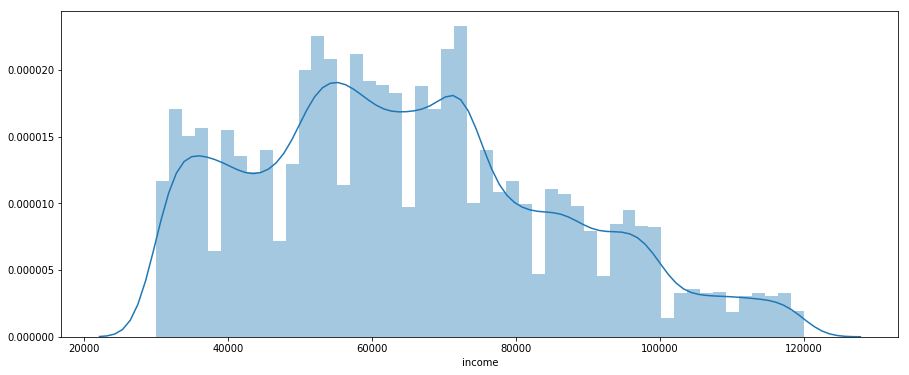

In [8]:
plt.figure(figsize=(15, 6))
sns.distplot(cleaned_data.income, kde = True)
plt.show()

From above density plot, we can see almost person has \\$40000 ~ \\$80000 income and some person get over \\$100000.

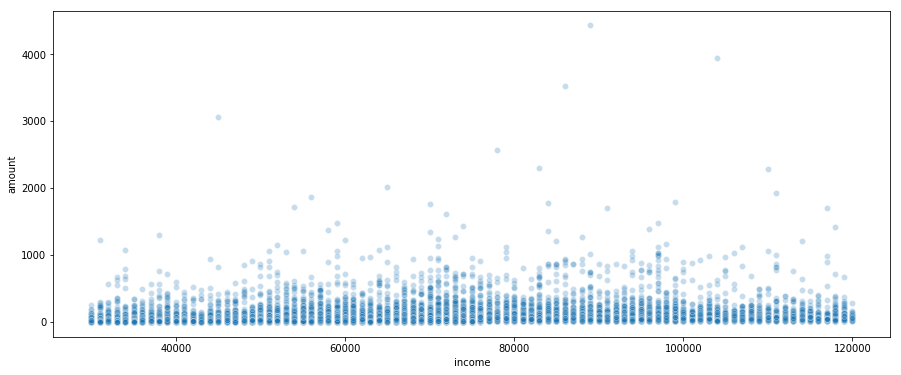

In [13]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='income', y='amount', data=cleaned_data, alpha=.25)
plt.show()

This figure is hard to see because almost `amount` has small values and it is too dense in small value area.  
In such cases let's try logarithmic conversion. It will improve the plot.

In [11]:
cleaned_data['log_amount'] = np.log(cleaned_data.amount)

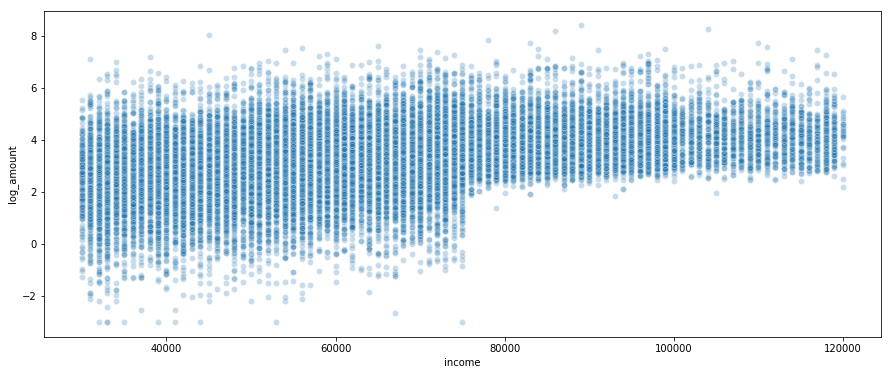

In [14]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='income', y='log_amount', data=cleaned_data, alpha=.25)
plt.show()

Looks good, and we can realize there are something like a boundary near the \\$80000.  
What's this? Let's close look at plot to find out where the boundaries are.

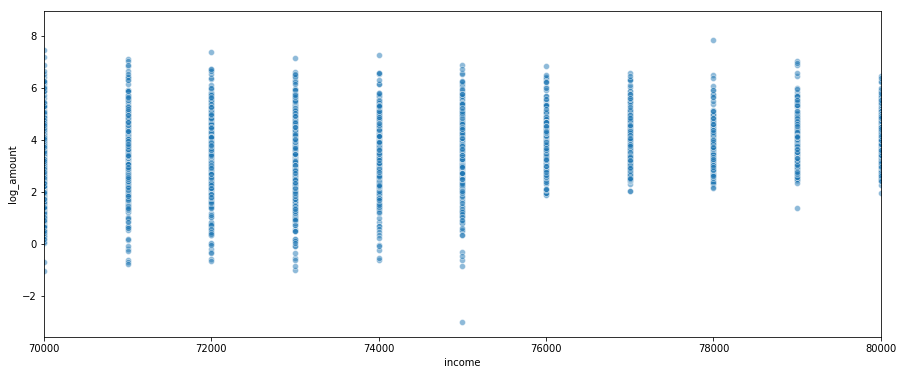

In [16]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='income', y='log_amount', data=cleaned_data, alpha=.5)
plt.xlim((70000, 80000))
plt.show()

The boundary lies near \\$75000.  
Why this boundary exist? It may be relate with `offer_type`. Let's cross the dimension.

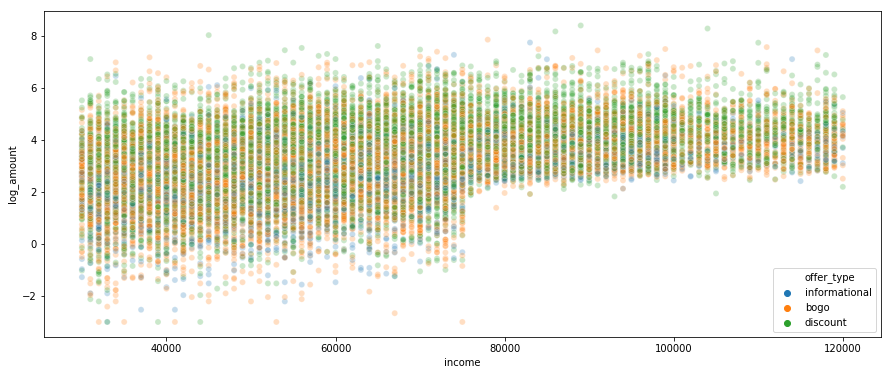

In [17]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='income', y='log_amount', data=cleaned_data, alpha=.25, hue='offer_type')
plt.show()

It has no relation with offer_type. I can't understand why the boundary exist, but we can use this information when building machine learning model.   
If I use tree-based model, the information will be useful because if income is higer than \\$75000, the target values will be higher than 2.

### Offer not related purchase amount

In the data cleaning step, I split data to offer related purchases and offer not related purchases, and I use offer related purchases to create target valuable, offer not related purchases to create features.

Offer not related purchase amount seems to be related with target valuable because it show customer's purchase ability and royality.  
Let's look at the corration with target.

I created some features from offer not related purchases, and I will look at below features.

* sum
* mean
* min
* std

I will apply log transformation to features same as target.

In [19]:
for col in ['amount_sum', 'amount_mean', 'amount_min', 'amount_std']:
    col_name = 'log_' + col
    cleaned_data[col_name] = np.log(cleaned_data[col])

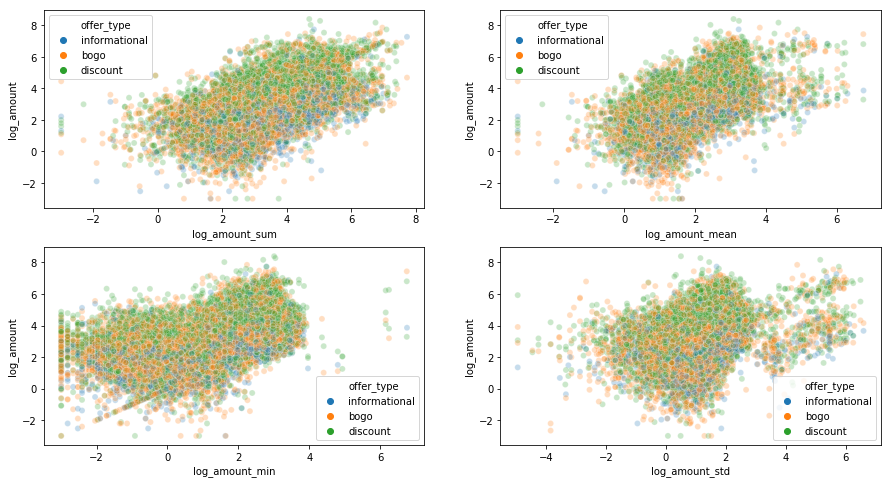

In [25]:
plt.figure(figsize=(15, 8))
for i, x in enumerate(['log_amount_sum', 'log_amount_mean', 'log_amount_min', 'log_amount_std']):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=x, y='log_amount', data=cleaned_data, alpha=.25, hue='offer_type')
plt.show()

There are corrations with amout_sum, amount_mean, amount_min, but amount_std may not be corrated with target.  
And from here, it looks like the target variance is large. It seems to be hard to explain the variance with simple model.

## Modeling

In this part, I will building the machine learning model. I will use [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) because through the EDA step, the target has non-linear relation with each features and may not be able to explain simple model. Random Forest Regressor can treat many small decision tree model so that it can adopt complex data and non-linear relation.

I will split model with each offer type. This is because I prevent the model overfit a offer type.   
For example the informational offer don't have `discount`, so the offer related purchases seem to be no relation with `discount` in informationa offer.  
But, the discount offer has `discount` value, and this may be related with the offer related purchases. If we build model with all data, we will ignore things like this.

In [33]:
# drop columns created to visualize
cleaned_data = cleaned_data.drop(['log_amount_sum', 'log_amount_mean', 'log_amount_min', 'log_amount_std'], axis=1)

In [35]:
# split data for each offer type
data_informational = cleaned_data[cleaned_data.offer_type == 'informational']
data_bogo = cleaned_data[cleaned_data.offer_type == 'bogo']
data_discount = cleaned_data[cleaned_data.offer_type == 'discount']

print('informational data length: ', len(data_informational))
print('bogo data length: ', len(data_bogo))
print('discount data length: ', len(data_discount))

informational data length:  4865
bogo data length:  15116
discount data length:  13644


Because of almost targets are low but a little of targets are high, it may be can't enough fitting normal scale.  
So, I will apply log transformation to target and treat it as target same as when I visualize.

In [45]:
def cross_validation(data):
    model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=0)
    X = data.drop([
        'person', 
        'offer_id', 
        'amount',
        'log_amount',
        'offer_type'
    ], axis=1)

    y = data['log_amount']
    scores = cross_val_score(model, X, y, cv=5)

    return scores

In [46]:
for data, offer_type in zip([data_bogo, data_discount, data_informational], ['bogo', 'discount', 'informational']):
    scores = cross_validation(data)
    print('{} mean score: {}'.format(offer_type, scores.mean()))
    print('{} scores: {} \n'.format(offer_type, scores))

bogo mean score: 0.4829501630127037
bogo scores: [0.48380955 0.4940746  0.47806762 0.50429059 0.45450846] 

discount mean score: 0.4950185035204693
discount scores: [0.51589922 0.50821142 0.48494338 0.47976652 0.48627198] 

informational mean score: 0.46568930422907273
informational scores: [0.48227171 0.48164195 0.45468433 0.4943833  0.41546523] 



Model performances can be said little good.
In the next section, I will try to improve the models.

## Evaluating

In this part, I will try below things to improve model performances.

* Model Stacking
* Model Ensembling
* Parameter Tuning

First, let's see how well the model predicts target values.

In [65]:
def model_predict(data):
    model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=0)
    X = data.drop([
        'person', 
        'offer_id', 
        'amount',
        'log_amount',
        'offer_type'
    ], axis=1)

    y = data['log_amount'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
    model.fit(X_train, y_train)
    
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    return y_test, y_pred_test, y_train, y_pred_train

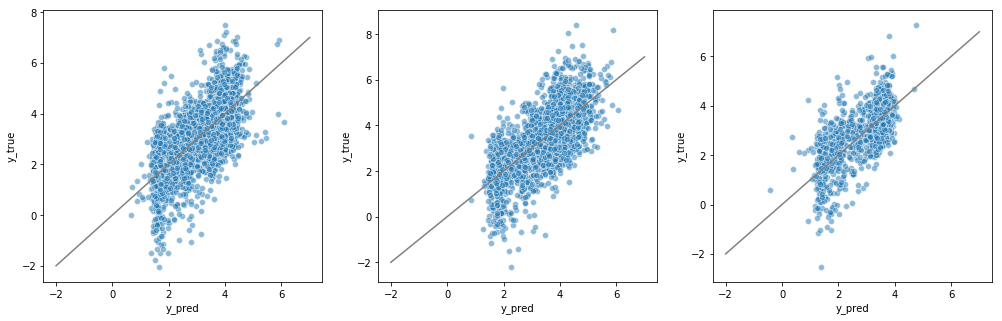

In [66]:
plt.figure(figsize=(17, 5))
for i, data in enumerate([data_bogo, data_discount, data_informational]): 
    y_true, y_pred, _, _ = model_predict(data)  
    plt.subplot(1, 3, i+1)
    plt.plot((-2, 7), (-2, 7), color='gray')
    sns.scatterplot(x=y_pred, y=y_true, alpha=.5)
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
plt.show()

From here, it looks like model working well, but there is also a part that model can't explain.

### Stacking

Stacking is the method of often using in the competition.  
The charactoristics of Stacking is that use predicted result as a feature and predict again. [more detail](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/)

In the above plot, it looks like it has a more steeper linear relationship than `y=x`. The Stacking method may work well, so let's try.

In [87]:
def stacking(data):
    y_test, y_pred_test, y_train, y_pred_train = model_predict(data)
    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
    input_train = np.stack([y_pred_train, y_pred_train**2]).T
    input_test = np.stack([y_pred_test, y_pred_test**2]).T
    model.fit(input_train, y_train)
    y_pred_stack = model.predict(input_test)
    return y_test, y_pred_stack

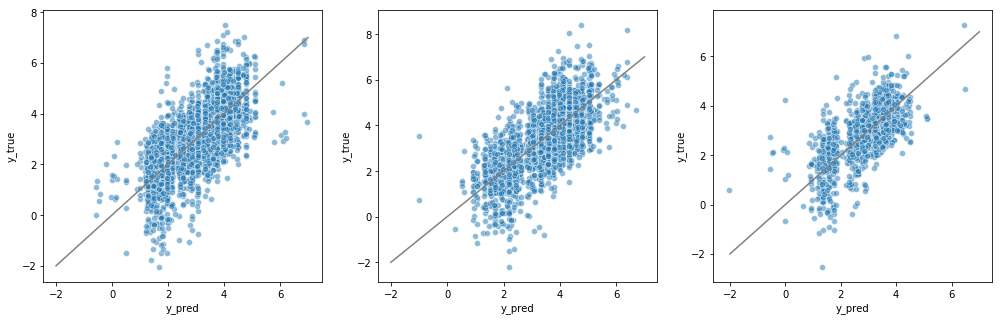

In [88]:
plt.figure(figsize=(17, 5))
for i, data in enumerate([data_bogo, data_discount, data_informational]): 
    y_true, y_pred = stacking(data)  
    plt.subplot(1, 3, i+1)
    plt.plot((-2, 7), (-2, 7), color='gray')
    sns.scatterplot(x=y_pred, y=y_true, alpha=.5)
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
plt.show()

It looks like the model has improved a bit. Let's culcurate R2 score.

In [90]:
for data, offer_type in zip([data_bogo, data_discount, data_informational], ['bogo', 'discount', 'informational']):
    y_true, y_pred = stacking(data)
    score = r2_score(y_true, y_pred)
    print('{} test score: {}'.format(offer_type, score))

bogo test score: 0.4690773434257177
discount test score: 0.4973650336665325
informational test score: 0.4092812539724372


As a result, the R2 score became a little bad. I think this is because the model became too complex.  
Stacking is not effective in this case, next I will try **Ensembling** method.

### Ensembling

ensembling is also the method of often using in the competition. Ensembling build some model and predict target values on the each model, then take a weighted average of those predicted values. [more detail](https://towardsdatascience.com/ensemble-methods-in-machine-learning-what-are-they-and-why-use-them-68ec3f9fef5f)

Ensembling is used model improvement, but it is used mainly to increase robustness of the predicted values.  
Let's try.

In [91]:
def ensembling(model1, model2, data):
    X = data.drop(['person', 'offer_id', 'amount', 'log_amount', 'offer_type'], axis=1)
    y = data['log_amount'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
    
    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    
    y_pred_test = (model1.predict(X_test) + model2.predict(X_test)) / 2
    y_pred_train = (model1.predict(X_train) + model2.predict(X_train)) / 2
    
    return y_test, y_pred_test, y_train, y_pred_train

In [107]:
for data, offer_type in zip([data_bogo, data_discount, data_informational], ['bogo', 'discount', 'informational']):
    model1 = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=100)
    model2 = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=0, learning_rate=0.1)
    y_test, y_pred_test, y_train, y_pred_train = ensembling(model1, model2, data)
    score_train = r2_score(y_train, y_pred_train)
    score_test = r2_score(y_test, y_pred_test)
    
    print('{} train score: {}'.format(offer_type, score_train))
    print('{} test score: {} \n'.format(offer_type, score_test))

bogo train score: 0.6654370347430032
bogo test score: 0.4803401875005221 

discount train score: 0.6968018211456134
discount test score: 0.5058464846066549 

informational train score: 0.7971545717201325
informational test score: 0.4337398334952478 



The bogo and discount model improved little, but the informational model seems to be overfit.  
There is other method such as change weights of each model or use theree or more models or use several type of argorithm.  
But the more increasing ensemble complex, the more calcuration time is needed. Because this is not a competition, I will use two model ensembling. 

In the previous part, I decided model parameters with no evidences.  
Next part, I try to optimize model parameters.

### Parameter Tuning

Parameter tuning is almost last part of building machine learning models. I think the sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is often used in many case, I will use it to models for each offer type. This step spent many many time.

In [119]:
# define param grid
rf_param_grid = {
    'max_depth' : [5, 8, 10],
    'min_samples_split' : [2, 5, 10]
}

gb_param_grid = {
    'learning_rate' : [0.01, 0.05, 0.1],
    'min_samples_split' : [2, 5, 10] 
}

In [120]:
# apply grid search
models = {}
for offer_type, data in zip(['bogo', 'discount', 'informational'], [data_bogo, data_discount, data_informational]):
    X = data.drop(['person', 'offer_id', 'amount', 'log_amount', 'offer_type'], axis=1)
    y = data['log_amount'].values
    
    rf_grid_search = GridSearchCV(RandomForestRegressor(n_estimators=100), rf_param_grid, cv=5)
    gb_grid_search = GridSearchCV(GradientBoostingRegressor(n_estimators=100, max_depth=5), gb_param_grid, cv=5)
    rf_grid_search.fit(X, y)
    gb_grid_search.fit(X, y)
    
    models[offer_type] = [rf_grid_search.best_estimator_, gb_grid_search.best_estimator_]
    
models

{'bogo': [RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=None, verbose=0, warm_start=False),
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='ls', max_depth=5, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=10, min_weight_fraction_leaf=0.0,
               n_estimators=100, n_iter_no_change=None, presort='auto',
               random_state=None, subsample=1.0, tol=0.0001,
               validation_fraction=0.1, verbose=0, warm_start=False)],
 'discount': [RandomForestRegressor(bootstrap=

In [127]:
# eval performance
for data, offer_type in zip([data_bogo, data_discount, data_informational], ['bogo', 'discount', 'informational']):
    model1 = models[offer_type][0]
    model2 = models[offer_type][1]
    y_test, y_pred_test, y_train, y_pred_train = ensembling(model1, model2, data)
    score_train = r2_score(y_train, y_pred_train)
    score_test = r2_score(y_test, y_pred_test)
    
    print('{} train score: {}'.format(offer_type, score_train))
    print('{} test score: {} \n'.format(offer_type, score_test))

bogo train score: 0.5652443009944752
bogo test score: 0.4898967543304543 

discount train score: 0.6213172582936874
discount test score: 0.5118875784679152 

informational train score: 0.5984538188628596
informational test score: 0.46235866689556593 



Here, each model is optimized for each offer type data. And performance of each models are best in this notebook.  
Now, It's ready to deploy.

## Deploy

In this step, I will predict offer related purchase amount for each offer with models which I built.  
Then, I show the profit increase if sent optimized offer.

In [135]:
cleaned_data.head()

,person,offer_id,amount,age,income,difficulty,duration,offer_type,reward,num_channel,...,gender_F,gender_M,gender_O,registar_year_2013,registar_year_2014,registar_year_2015,registar_year_2016,registar_year_2017,registar_year_2018,log_amount
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57,33,72000.0,0,4,informational,0,3,...,0,1,0,0,0,0,0,1,0,2.148268
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,33,72000.0,0,3,informational,0,3,...,0,1,0,0,0,0,0,1,0,3.098289
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,14.11,33,72000.0,5,5,bogo,5,4,...,0,1,0,0,0,0,0,1,0,2.646884
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,82.76,33,72000.0,10,10,discount,2,4,...,0,1,0,0,0,0,0,1,0,4.415945
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,45.08,40,57000.0,20,10,discount,5,2,...,0,0,1,0,0,0,0,0,1,3.808439


In [185]:
# create dataframe for predict
import_data = cleaned_data.drop(['offer_id', 'difficulty', 'duration', 'offer_type', 'reward', 'num_channel', 
                                 'channel_web', 'channel_email', 'channel_mobile', 'channel_social', 'amount',
                                 'log_amount', 'reward_inpact', 'discount_ratio', 'scaled_difficulty'], axis=1).drop_duplicates()

import_data['key'] = 1
portfolio['key'] = 1
import_data = import_data.merge(portfolio.drop('channels', axis=1), how='left', on='key')
import_data['reward_inpact'] = import_data.reward / import_data.income
import_data['discount_ratio'] = import_data.reward / import_data.difficulty
import_data['scaled_difficulty'] = import_data.difficulty / import_data.duration
import_data = import_data.fillna(0)
del import_data['key']
import_data.head()

,person,age,income,amount_min,amount_max,amount_sum,amount_mean,amount_count,amount_std,amount_median,...,offer_type,reward,num_channel,channel_web,channel_email,channel_mobile,channel_social,reward_inpact,discount_ratio,scaled_difficulty
0,0009655768c64bdeb2e877511632db8f,33,72000.0,8.57,28.16,91.88,15.313333,6.0,7.151281,13.235,...,bogo,10,3,0,1,1,1,0.000139,1.00,1.428571
1,0009655768c64bdeb2e877511632db8f,33,72000.0,8.57,28.16,91.88,15.313333,6.0,7.151281,13.235,...,bogo,10,4,1,1,1,1,0.000139,1.00,2.000000
2,0009655768c64bdeb2e877511632db8f,33,72000.0,8.57,28.16,91.88,15.313333,6.0,7.151281,13.235,...,informational,0,3,1,1,1,0,0.000000,0.00,0.000000
3,0009655768c64bdeb2e877511632db8f,33,72000.0,8.57,28.16,91.88,15.313333,6.0,7.151281,13.235,...,bogo,5,3,1,1,1,0,0.000069,1.00,0.714286
4,0009655768c64bdeb2e877511632db8f,33,72000.0,8.57,28.16,91.88,15.313333,6.0,7.151281,13.235,...,discount,5,2,1,1,0,0,0.000069,0.25,2.000000


In [186]:
predictions = pd.DataFrame()
for _, row in import_data.iterrows():
    person = row.person
    offer_type = row.offer_type
    offer_id = row.id
    row = row.drop(['person', 'id', 'offer_type']).values.reshape(1, -1)
    model1 = models[offer_type][0]
    model2 = models[offer_type][1]
    prediction = (model1.predict(row) + model2.predict(row)) / 2

    new_row = pd.DataFrame([[person, offer_id, offer_type, prediction]], columns=['person', 'offer_id', 'offer_type', 'predicted_log_amount'])
    predictions = predictions.append(new_row)

In [198]:
predictions = predictions.reset_index().drop('index', axis=1)

In [211]:
idx = predictions.groupby('person')['predicted_log_amount'].transform(max) == predictions['predicted_log_amount']
optimized_offer = predictions[idx]
optimized_offer['predicted_log_amount'] = optimized_offer.predicted_log_amount.map(lambda x: x[0])
optimized_offer['predicted_amount'] = np.exp(optimized_offer.predicted_log_amount)
optimized_offer.tail()

ValueError: Lengths must match to compare

## Conclusion